# Merge the nearbed SUNTANS data

see: `SCRIPTS\convert_surface_seabed_suntans_mpi.py`

In [1]:
# Use a dask client
from dask.distributed import Client, LocalCluster, worker, progress, wait
import dask
from dask import delayed
from dask_jobqueue import SLURMCluster

In [2]:
cluster = SLURMCluster()
client=Client(cluster)
cluster.scale(4)
client

<Client: scheduler='tcp://146.118.38.43:39571' processes=0 cores=0>

In [3]:
#from soda.dataio.suntans.sunpy import Spatial
import xarray as xr
import dask
from netCDF4 import Dataset
import numpy as np
from glob import glob
from datetime import datetime

from soda.dataio.suntans.sunxray import Sundask
#from soda.dataio.suntans.sunpy import Spatial
from soda.utils.fkriging import kriging


from soda.utils.myproj import MyProj
from soda.utils.otherplot import axcolorbar

import matplotlib.animation as animation
from IPython.display import HTML

from matplotlib import rcParams
from tqdm import tqdm
import os

from netCDF4 import Dataset

#rcParams['font.family'] = 'sans-serif'
#rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
#rcParams['font.serif'] = ['Bitstream Vera Sans']
rcParams["font.size"] = "14"
rcParams['axes.labelsize']='large'

import matplotlib.pyplot as plt

In [4]:
%matplotlib notebook

In [5]:
# Load one month
def load_suntans(ncfile, timedim='time'):
    sun = Sundask(ncfile, timedim=timedim)
    sun.cells[sun.cells<0] = 0
    
    # Set the projection
    P = MyProj('merc')
    sun.xp, sun.yp = P.to_ll(sun.xp, sun.yp)
    sun.xv, sun.yv = P.to_ll(sun.xv, sun.yv)
    sun._xy = None # reset this
    
    return sun

In [6]:
class SunInterp(object):
    def __init__(self, sun, X, Y, **kwargs):
        self.sun = sun
        # Build an interpolation object
        xyin = np.array([sun.xv.ravel(), sun.yv.ravel()]).T
        xyout = np.array([X.ravel(), Y.ravel()]).T
        self.F = kriging(xyin, xyout, **kwargs)
        self.cellidx = sun.find_cell(X.ravel(), Y.ravel())
        self.ny, self.nx = X.shape 
    def __call__(self, data, klayer=0):
        # Interpolate
        Z =self.F(data)

        # NaN out points < klayer
        kidx = self.sun.Nk[self.cellidx] < klayer+1
        Z[kidx] = np.nan

        # Nan out cells out side of the range
        Z[self.cellidx==-1] = np.nan
        Z = Z.reshape((self.ny,self.nx))
        
        return Z

class SunNearest(object):
    def __init__(self, sun, X, Y, **kwargs):
        self.sun = sun
        # Build an interpolation object
        self.cellidx = sun.find_cell(X.ravel(), Y.ravel())
        self.ny, self.nx = X.shape 
    def __call__(self, data, klayer=0):
        # Interpolate
        Z =data[self.cellidx]

        # NaN out points < klayer
        kidx = self.sun.Nk[self.cellidx] < klayer+1
        Z[kidx] = np.nan

        # Nan out cells out side of the range
        Z[self.cellidx==-1] = np.nan
        Z = Z.reshape((self.ny,self.nx))
        
        return Z

In [7]:
# Interpolate and save a variable
def interp_var(varname, sun, F, nt=None):
    if nt is None:
        nt = sun.Nt
        
    data = sun.load_data(varname, tstep=slice(0,nt))
    outvar = np.zeros((nt,F.ny,F.nx))
    
    for ii in tqdm(range(nt)):
        outvar[ii,...] = F(data[ii,...])
        
    return xr.DataArray(outvar, \
        dims=('time', 'latitude', 'longitude'),
        coords = {'time':sun._ds.time[0:nt],\
                 'latitude':y,
                 'longitude':x},
        attrs = {'units':sun._ds[varname].units,\
                'long_name':sun._ds[varname].long_name\
                }
                   )#.chunk({'latitude':100, 'longitude':100})

def interp_var_delayed(varname, sun, F, nt=None):
    if nt is None:
        nt = sun.Nt
        
    #data = dask.array.from_array(sun.load_data(varname, tstep=slice(0,nt)), chunks={'time':1})
    #data = sun.load_data(varname, tstep=slice(0,nt))
    data = sun.get_data(varname, tstep=slice(0,nt))


    #outvar = np.zeros((nt,F.ny,F.nx))
    
    outvar = []
    for ii in tqdm(range(nt)):
        #data = sun.load_data(varname, tstep=ii)
        outvar.append(
            dask.array.from_array(F(data[ii,sun.ghost]), chunks={'time':1})
            #shape=(F.ny,F.nx), dtype=np.float64 )
        )
    
    return xr.DataArray( dask.array.stack(outvar, axis=0), \
        dims=('time', 'latitude', 'longitude'),
        coords = {'time':sun._ds.time[0:nt],\
                 'latitude':y,
                 'longitude':x},
        attrs = {'units':sun._ds[varname].units,\
                'long_name':sun._ds[varname].long_name\
                }
                   )

In [8]:
#####
# Output grid
# Whole suntans domain
# xlims = [107.5,142.5]
# ylims = [-25.0,-5.0]

# Reduced domain
xlims = [110.0,135.0]
ylims = [-23.0,-8.0]

dx = 0.02 # 2 km resolution


# List all of the netcdf files
dates = ['20130701','20130801','20130901','20131001','20131101','20131201','20140101',\
        '20140201','20140301','20140401','20140501','20140601']
filestrs=[]
for ii, mydate in enumerate(dates):
    filestrs.append('../SCENARIOS/NWS_2km_hex_2013_2014_data{}/NWS_2km_hex_{}.nc.*.bed'.format(ii+1,mydate))

#outfile = '../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014/NWS_2km_hex_20130701_seabed_interp.nc'
outdir = '../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014/'

varnames = ['uc','vc','temp']
nt = None # Set to None to process all time steps



In [20]:
# output the merged near-bed layer thickness
myfile = 'NWS_2km_hex_seabed_thickness'
dzfile = '../SCENARIOS/NWS_2km_hex_2013_2014_data1/{}.nc.*'.format(myfile)

sundz = load_suntans(dzfile)
# nc = Dataset(dzfile)
# nc.close()

# xr.open_dataset(dzfile)

Time dimension time
No time dimesion
converting variable: xp
converting variable: yp


In [23]:
# Create an output file with the bed thickness
# Create the interpolation class
x = np.arange(xlims[0],xlims[1],dx)
y = np.arange(ylims[0],ylims[1],dx)
X,Y = np.meshgrid(x,y)

print('Building interpolation object...')
Finterp = SunNearest(sundz, X, Y)
depths_2d = Finterp(sundz.dv)

outfile = '{}/{}_interp.nc'.format(outdir,myfile)
# Create the output data set
print('\tCreating output file %s...'%outfile)
z = xr.DataArray(depths_2d, \
        dims=('latitude', 'longitude'),
        coords = {'latitude':y,
                 'longitude':x},
        attrs = {'units':'m',\
                'long_name':'Depth'\
                }
                   )
# Interpolate the seabed thickness
dzbed = Finterp(sundz.load_data('dzbed'))

dz = xr.DataArray(dzbed, \
        dims=('latitude', 'longitude'),
        coords = {'latitude':y,
                 'longitude':x},
        attrs = {'units':'m',\
                'long_name':'Near-bed layer thickness'\
                }
                   )


dsout = xr.Dataset({ 'z':z,'dzbed':dz},
                   attrs = {
                    'Name':'North West Shelf SUNTANS seabed thickness',
                    'Date created': datetime.now().strftime('%Y:%m:%d %H:%M:%S'),
                    'Author':'Matt Rayson',
                    'Institution':'University of Western Australia',
                   }
                  )
    
dsout.to_netcdf(outfile, format='NETCDF4_CLASSIC', mode='w',\
        encoding={'dzbed':{'zlib':1},'z':{'zlib':1}})
dsout


Building interpolation object...
	Creating output file ../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014//NWS_2km_hex_seabed_thickness_interp.nc...


<xarray.Dataset>
Dimensions:    (latitude: 750, longitude: 1250)
Coordinates:
  * latitude   (latitude) float64 -23.0 -22.98 -22.96 ... -8.06 -8.04 -8.02
  * longitude  (longitude) float64 110.0 110.0 110.0 110.1 ... 134.9 135.0 135.0
Data variables:
    z          (latitude, longitude) float64 nan nan nan ... 107.4 107.4 106.1
    dzbed      (latitude, longitude) float64 nan nan nan ... 9.755 9.755 8.512
Attributes:
    Name:          North West Shelf SUNTANS seabed thickness
    Date created:  2019:10:22 10:31:47
    Author:        Matt Rayson
    Institution:   University of Western Australia

In [10]:
# For each file interpolate the seabed velocity
Finterp = None
for filestr in filestrs:
    myfile = filestr.split('/')[-1].split('.')[0]

    outfile = '{}/{}_seabed_interp.nc'.format(outdir,myfile)
    if os.path.isfile(outfile):
        print('File exists... moving on')
        continue
        
    print(filestr)
    #print(outfile)
    # Load the suntans file
    sun = load_suntans(filestr)

    
    # Create the interpolation class
    x = np.arange(xlims[0],xlims[1],dx)
    y = np.arange(ylims[0],ylims[1],dx)
    X,Y = np.meshgrid(x,y)
    
    if Finterp is None:
        print('Building interpolation object...')
        Finterp = SunNearest(sun, X, Y)
        depths_2d = Finterp(sun.dv)
    
    # Create the output data set
    print('\tCreating output file %s...'%outfile)
    z = xr.DataArray(depths_2d, \
            dims=('latitude', 'longitude'),
            coords = {'latitude':y,
                     'longitude':x},
            attrs = {'units':'m',\
                    'long_name':'Depth'\
                    }
                       )

    dsout = xr.Dataset({ 'z':z,},
                       attrs = {
                        'Name':'North West Shelf SUNTANS seabed data',
                        'Date created': datetime.now().strftime('%Y:%m:%d %H:%M:%S'),
                        'Author':'Matt Rayson',
                        'Institution':'University of Western Australia',
                        'Input Files':filestr
                       }
                      )
    
    mode='w'
    dsout.to_netcdf(outfile, format='NETCDF4_CLASSIC', mode=mode)
    
    mode = 'a'
    # Loop through each variable and write to disk
    for varname in varnames:
        print('\tProcessing variable %s...'%varname)
        data_a = interp_var(varname, sun, Finterp, nt=nt)
        
        dsout = xr.Dataset({varname:data_a})
        #print('\tWriting to disk...')
        dsout.to_netcdf(outfile, format='NETCDF4_CLASSIC', mode=mode,)
        #    encoding={varname:{'zlib':1}})
        
        #break
    #break
    
    


File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
File exists... moving on
../SCENARIOS/NWS_2km_hex_2013_2014_data11/NWS_2km_hex_20140501.nc.*.bed
Time dimension time
converting variable: xp
converting variable: yp
Building interpolation object...
	Creating output file ../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014//NWS_2km_hex_20140501_seabed_interp.nc...
	Processing variable uc...


100%|██████████| 745/745 [00:34<00:00, 21.30it/s]


	Processing variable vc...


100%|██████████| 745/745 [00:44<00:00, 16.62it/s]


	Processing variable temp...


100%|██████████| 745/745 [04:19<00:00,  2.87it/s]


File exists... moving on


In [50]:
, outfile

(True,
 '../SCENARIOS/OUTPUT_NWS_2km_hex_2013_2014//NWS_2km_hex_20130701_seabed_interp.nc')

# Testing

In [7]:

sun = load_suntans(filestr)
#sun._ds

Time dimension time
converting variable: xp
converting variable: yp


<xarray.Dataset>
Dimensions:  (Nc: 1245, Ne: 3953, Nk: 1, Nkw: 2, Np: 454016, numsides: 8, time: 745, two: 2)
Coordinates:
    xv       (Nc) float64 dask.array<shape=(1245,), chunksize=(1245,)>
    yv       (Nc) float64 dask.array<shape=(1245,), chunksize=(1245,)>
    xe       (Ne) float64 dask.array<shape=(3953,), chunksize=(3953,)>
    ye       (Ne) float64 dask.array<shape=(3953,), chunksize=(3953,)>
    Nk       (Nc) int32 dask.array<shape=(1245,), chunksize=(1245,)>
  * time     (time) datetime64[ns] 2013-07-01T00:00:30 2013-07-01T01:00:00 ...
Dimensions without coordinates: Nc, Ne, Nkw, Np, numsides, two
Data variables:
    xp       (Np) float64 dask.array<shape=(454016,), chunksize=(454016,)>
    yp       (Np) float64 dask.array<shape=(454016,), chunksize=(454016,)>
    lonv     (Nc) float64 dask.array<shape=(1245,), chunksize=(1245,)>
    latv     (Nc) float64 dask.array<shape=(1245,), chunksize=(1245,)>
    lonp     (Np) float64 dask.array<shape=(454016,), chunksize=(454016,)>

In [2]:
# Create the interpolation object
x = np.arange(xlims[0],xlims[1],dx)
y = np.arange(ylims[0],ylims[1],dx)
X,Y = np.meshgrid(x,y)

Finterp = SunNearest(sun, X, Y)


NameError: name 'np' is not defined

In [16]:
#Fkrig = SunInterp(sun, X, Y, maxdist=2e4, vrange=2000.)
depths_2d = Finterp(sun.dv)

In [12]:
uout = interp_var('uc', sun, Finterp, nt=nt)

100%|██████████| 745/745 [02:34<00:00,  4.82it/s]


<IPython.core.display.Javascript object>


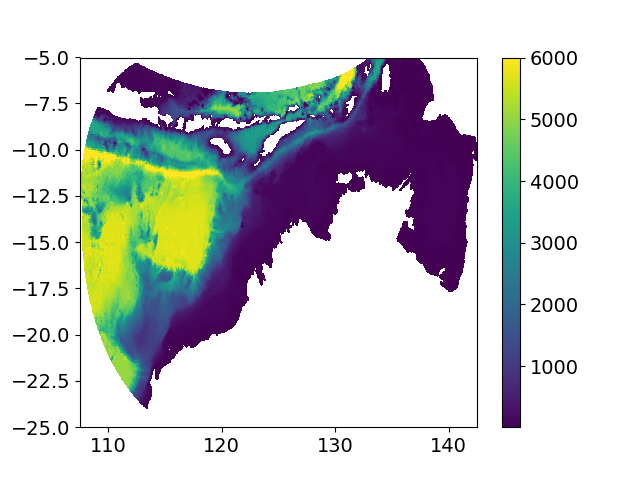

In [20]:
plt.figure()
#plt.pcolormesh(X,Y,uout.max(axis=0))
plt.pcolormesh(X,Y,depths_2d)

plt.colorbar()

In [1]:
745*1000*1750*8*1e-9

10.430000000000001

In [25]:
sun._ds.time

<xarray.DataArray 'time' (time: 745)>
array(['2013-07-01T00:00:30.000000000', '2013-07-01T01:00:00.000000000',
       '2013-07-01T02:00:00.000000000', ..., '2013-07-31T22:00:00.000000000',
       '2013-07-31T23:00:00.000000000', '2013-08-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2013-07-01T00:00:30 2013-07-01T01:00:00 ...
Attributes:
    long_name:  time

In [34]:
# Create an output dataset


z = xr.DataArray(depths_2d, \
        dims=('latitude', 'longitude'),
        coords = {'latitude':y,
                 'longitude':x},
        attrs = {'units':'m',\
                'long_name':'Depth'\
                }
                   )


dsout = xr.Dataset({ 'z':z, varname:data_a},
                   attrs = {
                    'Name':'North West Shelf SUNTANS seabed data',
                    'Date created': datetime.now().strftime('%Y:%m:%d %H:%M:%S'),
                    'Author':'Matt Rayson',
                    'Institution':'University of Western Australia',
                    'Input Files':filestr
                   }
                  )

dsout

<xarray.Dataset>
Dimensions:    (latitude: 1000, longitude: 1750, time: 745)
Coordinates:
  * latitude   (latitude) float64 -25.0 -24.98 -24.96 -24.94 -24.92 -24.9 ...
  * longitude  (longitude) float64 107.5 107.5 107.5 107.6 107.6 107.6 107.6 ...
  * time       (time) datetime64[ns] 2013-07-01T00:00:30 2013-07-01T01:00:00 ...
Data variables:
    z          (latitude, longitude) float64 nan nan nan nan nan nan nan nan ...
    uc         (time, latitude, longitude) float64 nan nan nan nan nan nan ...
Attributes:
    Name:          North West Shelf SUNTANS seabed data
    Date created:  2019:08:28 10:56:24
    Author:        Matt Rayson
    Institution:   University of Western Australia
    Input Files:   ../SCENARIOS/NWS_2km_hex_2013_2014_data1/NWS_2km_hex_20130...

In [ ]:
mode='w'
dsout.to_netcdf(outfile, format='NETCDF4_CLASSIC', mode=mode,
         encoding={varname:{'zlib':1}})

/home/mrayson/anaconda2/envs/soda/lib/python3.6/site-packages/dask/utils.py:1014: UserWarning: Deprecated, see dask.base.get_scheduler instead
  warnings.warn("Deprecated, see dask.base.get_scheduler instead")


In [ ]:
!ls ../SCE